In [1]:
# Option B Pipeline: Pseudo‑Label Fine‑Tuning on MarBERT (using full 21k unlabeled)

# 0) (Optional) Install dependencies
!pip install torch==2.5.1+cu124 torchvision==0.20.1+cu124 --extra-index-url https://download.pytorch.org/whl/cu124




import pandas as pd
import numpy as np
import torch
import math
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 1) Device
device = "cuda" if torch.cuda.is_available() else "cpu"








Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 20.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu1

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:

# 2) Load labeled splits
def load_split(path):
    df = pd.read_csv(path, sep="\t")
    df = df.rename(columns={"sentence": "text", "average_dialectness_level": "label"})
    df["label"] = df["label"].astype(float)
    return Dataset.from_pandas(df)

train_ds = load_split("/content/train.tsv")
dev_ds   = load_split("/content/dev.tsv")
test_ds  = load_split("/content/test.tsv")

# 3) Load unlabeled pool + pseudo-label
df_unlab    = pd.read_csv("/content/unlabeled.tsv", sep="\t", encoding="latin1")
text_col    = [c for c in df_unlab.columns if "tweet" in c.lower()][0]
texts_unlab = df_unlab[text_col].astype(str).tolist()


In [4]:
# 4) Tokenizer & base model for embeddings
MODEL_NAME  = "UBC-NLP/MARBERTv2"
tokenizer   = AutoTokenizer.from_pretrained(MODEL_NAME)
embed_model = AutoModel.from_pretrained(MODEL_NAME).to(device)
embed_model.eval()

def get_cls_embeddings(texts, batch_size=32):
    embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        toks  = tokenizer(batch, padding=True, truncation=True,
                          max_length=128, return_tensors="pt").to(device)
        with torch.no_grad():
            hidden = embed_model(**toks).last_hidden_state
        embs.append(hidden[:,0].cpu().numpy())
    return np.vstack(embs)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
X_train = get_cls_embeddings(train_ds["text"])
y_train = np.array(train_ds["label"])

num_clusters   = len(np.unique(y_train))
km             = KMeans(n_clusters=num_clusters, random_state=42).fit(X_train)
clusters_train = km.labels_


In [6]:

cluster_means = {
    c: np.mean(y_train[clusters_train == c])
    for c in np.unique(clusters_train)
}
X_unlab        = get_cls_embeddings(texts_unlab)
clusters_unlab = km.predict(X_unlab)
pseudo_labels  = [cluster_means[c] for c in clusters_unlab]


In [7]:
# 5) Tokenization helper
def preprocess(batch):
    toks = tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)
    toks["labels"] = batch["label"]
    return toks

train_tok = train_ds.map(preprocess, batched=True)
dev_tok   = dev_ds.map(preprocess,   batched=True)
test_tok  = test_ds.map(preprocess,  batched=True)


Map:   0%|          | 0/102886 [00:00<?, ? examples/s]

Map:   0%|          | 0/12260 [00:00<?, ? examples/s]

Map:   0%|          | 0/12689 [00:00<?, ? examples/s]

In [8]:
# 6) Corrected metrics function
def compute_metrics_sup(pred):
    preds  = pred.predictions.squeeze(-1)
    labels = pred.label_ids.astype(float)
    mse    = mean_squared_error(labels, preds)
    return {
        "mse": mse,
        "rmse": math.sqrt(mse),
        "mae": mean_absolute_error(labels, preds)
    }


In [9]:

# 7) Supervised-only fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=1, problem_type="regression"
).to(device)

sup_args = TrainingArguments(
    output_dir                  ="./marbert_supervised",
    learning_rate               =2e-5,
    per_device_train_batch_size =16,
    per_device_eval_batch_size  =32,
    num_train_epochs            =3,
    logging_steps               =50,
    save_total_limit            =1,
    report_to                   =[],
    run_name                    ="marbert_supervised_reg",
    fp16                        =False,
)

sup_trainer = Trainer(
    model           =model,
    args            =sup_args,
    train_dataset   =train_tok,
    eval_dataset    =dev_tok,
    compute_metrics =compute_metrics_sup,
)
sup_trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.090600
100,0.051200
150,0.044300
200,0.045400
250,0.036900
300,0.041600
350,0.034600
400,0.040400
450,0.041300
500,0.036100


TrainOutput(global_step=19293, training_loss=0.02272385354485203, metrics={'train_runtime': 2053.635, 'train_samples_per_second': 150.298, 'train_steps_per_second': 9.395, 'total_flos': 2.0302650740381184e+16, 'train_loss': 0.02272385354485203, 'epoch': 3.0})

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 8) Error Analysis After Supervised Only
sup_out    = sup_trainer.predict(test_tok)
sup_preds  = sup_out.predictions.squeeze(-1)
labels     = sup_out.label_ids.astype(float)
sup_resids = sup_preds - labels

rmse_sup = math.sqrt(mean_squared_error(labels, sup_preds))
mae_sup  = mean_absolute_error(labels, sup_preds)
r2_sup   = r2_score(labels, sup_preds)
print(f"\n[Supervised-only] Test RMSE: {rmse_sup:.4f}, MAE: {mae_sup:.4f}, R²: {r2_sup:.4f}")



[Supervised-only] Test RMSE: 0.1681, MAE: 0.0997, R²: 0.7609


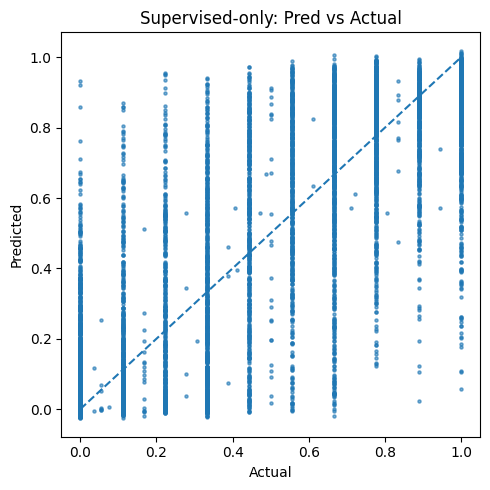

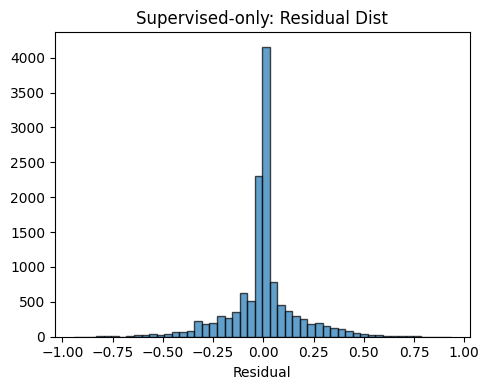

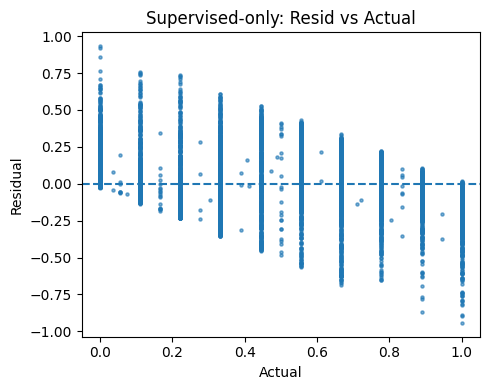

In [12]:

# Diagnostic plots
plt.figure(figsize=(5,5))
plt.scatter(labels, sup_preds, s=5, alpha=0.6); mn, mx = labels.min(), labels.max()
plt.plot([mn,mx],[mn,mx],"--"); plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title("Supervised-only: Pred vs Actual"); plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.hist(sup_resids, bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Residual"); plt.title("Supervised-only: Residual Dist"); plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.scatter(labels, sup_resids, s=5, alpha=0.6)
plt.axhline(0, linestyle="--"); plt.xlabel("Actual"); plt.ylabel("Residual")
plt.title("Supervised-only: Resid vs Actual"); plt.tight_layout(); plt.show()

In [13]:
# 9) Pseudo-labeled fine-tuning (continuation)
pseudo_ds  = Dataset.from_pandas(pd.DataFrame({"text": texts_unlab, "label": pseudo_labels}))
pseudo_tok = pseudo_ds.map(preprocess, batched=True)

pseudo_args = TrainingArguments(
    output_dir                  ="./marbert_pseudo_finetune_full",
    learning_rate               =2e-5,
    per_device_train_batch_size =16,
    per_device_eval_batch_size  =32,
    num_train_epochs            =1,
    logging_steps               =50,
    save_total_limit            =1,
    report_to                   =[],
    run_name                    ="marbert_pseudo_full_finetune",
    fp16                        =False,
)

pseudo_trainer = Trainer(
    model           =sup_trainer.model,
    args            =pseudo_args,
    train_dataset   =pseudo_tok,
    eval_dataset    =dev_tok,
    compute_metrics =compute_metrics_sup,
)
pseudo_trainer.train()

Map:   0%|          | 0/21000 [00:00<?, ? examples/s]

Step,Training Loss
50,0.002900
100,0.001900
150,0.001800
200,0.001500
250,0.001500
300,0.001400
350,0.001400
400,0.001400
450,0.001400
500,0.001200


TrainOutput(global_step=1313, training_loss=0.0012969971710343627, metrics={'train_runtime': 140.0756, 'train_samples_per_second': 149.919, 'train_steps_per_second': 9.374, 'total_flos': 1381320638208000.0, 'train_loss': 0.0012969971710343627, 'epoch': 1.0})

In [14]:


# 10) Error Analysis After Pseudo-Fine-Tuning
pseudo_out     = pseudo_trainer.predict(test_tok)
pseudo_preds   = pseudo_out.predictions.squeeze(-1)
pseudo_resids  = pseudo_preds - labels

rmse_pseudo = math.sqrt(mean_squared_error(labels, pseudo_preds))
mae_pseudo  = mean_absolute_error(labels, pseudo_preds)
r2_pseudo   = r2_score(labels, pseudo_preds)
print(f"\n[After Pseudo] Test RMSE: {rmse_pseudo:.4f}, MAE: {mae_pseudo:.4f}, R²: {r2_pseudo:.4f}")



[After Pseudo] Test RMSE: 0.2400, MAE: 0.2108, R²: 0.5126


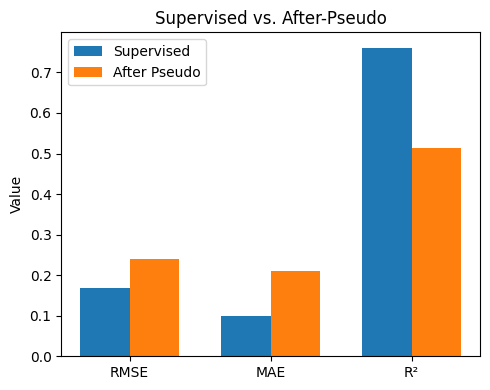

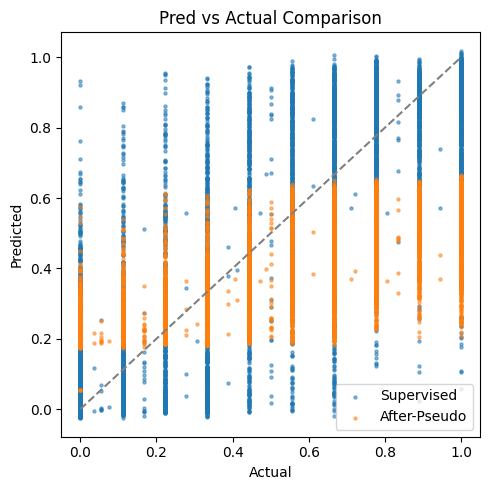

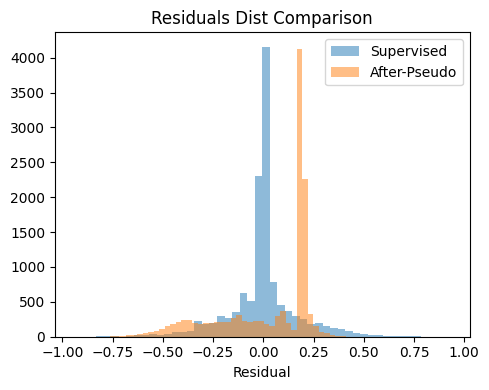

In [15]:


# Comparative Bar Chart
metrics = ["RMSE","MAE","R²"]
vals_sup    = [rmse_sup, mae_sup, r2_sup]
vals_pseudo = [rmse_pseudo, mae_pseudo, r2_pseudo]
x = np.arange(len(metrics)); w=0.35

plt.figure(figsize=(5,4))
plt.bar(x-w/2, vals_sup,    w, label="Supervised")
plt.bar(x+w/2, vals_pseudo, w, label="After Pseudo")
plt.xticks(x, metrics); plt.ylabel("Value"); plt.title("Supervised vs. After-Pseudo")
plt.legend(); plt.tight_layout(); plt.show()

# Overlay Pred vs Actual Comparison
plt.figure(figsize=(5,5))
plt.scatter(labels, sup_preds,    s=5, alpha=0.5, label="Supervised")
plt.scatter(labels, pseudo_preds, s=5, alpha=0.5, label="After-Pseudo")
plt.plot([mn,mx],[mn,mx],"--", color="gray")
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("Pred vs Actual Comparison")
plt.legend(); plt.tight_layout(); plt.show()

# Overlay Residual Distributions
plt.figure(figsize=(5,4))
plt.hist(sup_resids,    bins=50, alpha=0.5, label="Supervised")
plt.hist(pseudo_resids, bins=50, alpha=0.5, label="After-Pseudo")
plt.xlabel("Residual"); plt.title("Residuals Dist Comparison")
plt.legend(); plt.tight_layout(); plt.show()

🔹 Supervised-only Metrics: {'RMSE': 0.24002371123506264, 'MAE': 0.21077234012186552, 'R²': 0.5125914096198977}
🔹 After-Pseudo Metrics:   {'RMSE': 0.24002371123506264, 'MAE': 0.21077234012186552, 'R²': 0.5125914096198977}


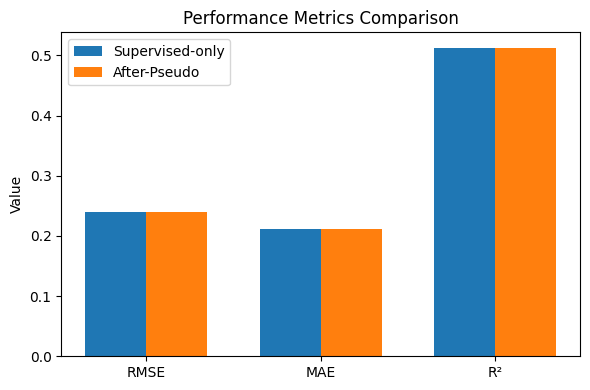

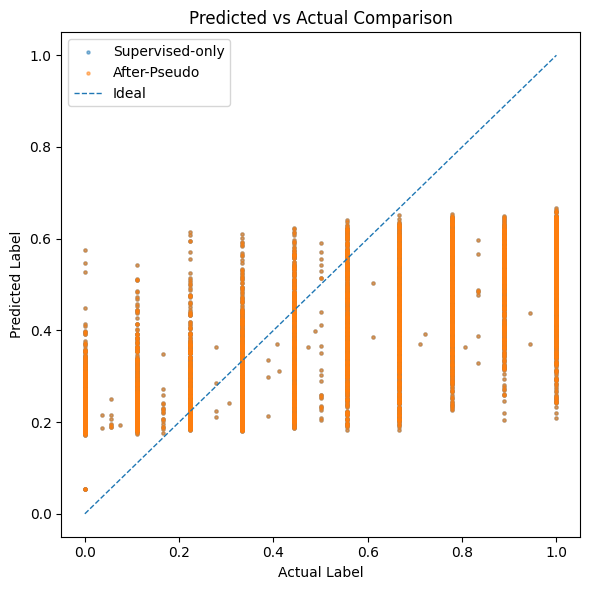

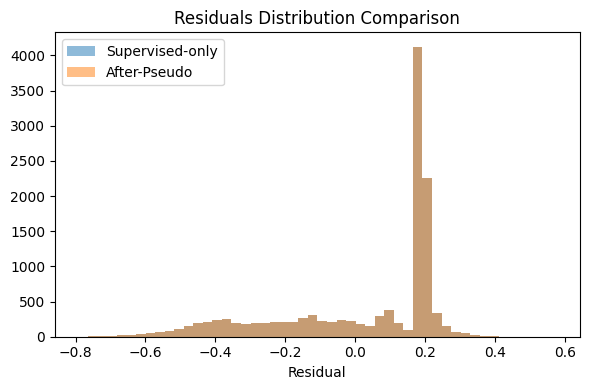

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure the required objects exist
if 'sup_trainer' not in globals() or 'pseudo_trainer' not in globals() or 'test_tok' not in globals():
    raise RuntimeError("Please run the cells that define and train 'sup_trainer', 'pseudo_trainer', and prepare 'test_tok' first.")

# 1) Predictions
sup_out      = sup_trainer.predict(test_tok)
sup_preds    = sup_out.predictions.squeeze(-1)
labels       = sup_out.label_ids.astype(float)
sup_resids   = sup_preds - labels

pseudo_out   = pseudo_trainer.predict(test_tok)
pseudo_preds = pseudo_out.predictions.squeeze(-1)
pseudo_resids= pseudo_preds - labels

# 2) Metrics
def all_metrics(true, pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(true, pred)),
        "MAE":  mean_absolute_error(true, pred),
        "R²":   r2_score(true, pred)
    }

sup_metrics    = all_metrics(labels, sup_preds)
pseudo_metrics = all_metrics(labels, pseudo_preds)

print("🔹 Supervised-only Metrics:", sup_metrics)
print("🔹 After-Pseudo Metrics:  ", pseudo_metrics)

# 3) Bar Chart Comparison
metrics_names = list(sup_metrics.keys())
sup_vals      = [sup_metrics[m] for m in metrics_names]
pseudo_vals   = [pseudo_metrics[m] for m in metrics_names]

x = np.arange(len(metrics_names))
w = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - w/2, sup_vals, width=w, label='Supervised-only')
plt.bar(x + w/2, pseudo_vals, width=w, label='After-Pseudo')
plt.xticks(x, metrics_names)
plt.ylabel('Value')
plt.title('Performance Metrics Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# 4) Predicted vs Actual Overlay
plt.figure(figsize=(6,6))
plt.scatter(labels, sup_preds,    s=5, alpha=0.5, label='Supervised-only')
plt.scatter(labels, pseudo_preds, s=5, alpha=0.5, label='After-Pseudo')
mn = min(labels.min(), sup_preds.min(), pseudo_preds.min())
mx = max(labels.max(), sup_preds.max(), pseudo_preds.max())
plt.plot([mn, mx], [mn, mx], '--', linewidth=1, label='Ideal')
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.title('Predicted vs Actual Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# 5) Residuals Distribution Comparison
plt.figure(figsize=(6,4))
plt.hist(sup_resids,    bins=50, alpha=0.5, label='Supervised-only')
plt.hist(pseudo_resids, bins=50, alpha=0.5, label='After-Pseudo')
plt.xlabel('Residual')
plt.title('Residuals Distribution Comparison')
plt.legend()
plt.tight_layout()
plt.show()


🔹 Supervised-only Metrics: {'RMSE': 0.24002371123506264, 'MAE': 0.21077234012186552, 'R²': 0.5125914096198977}
🔹 After-Pseudo Metrics:   {'RMSE': 0.24002371123506264, 'MAE': 0.21077234012186552, 'R²': 0.5125914096198977}


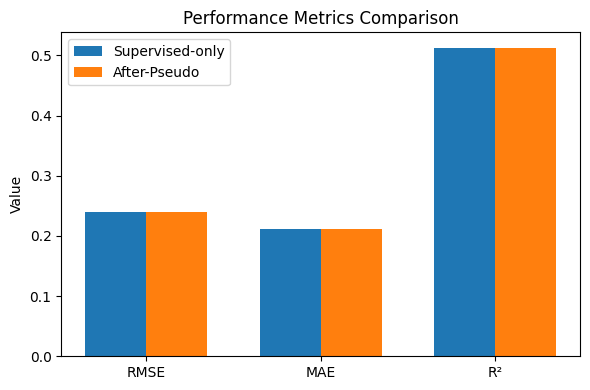

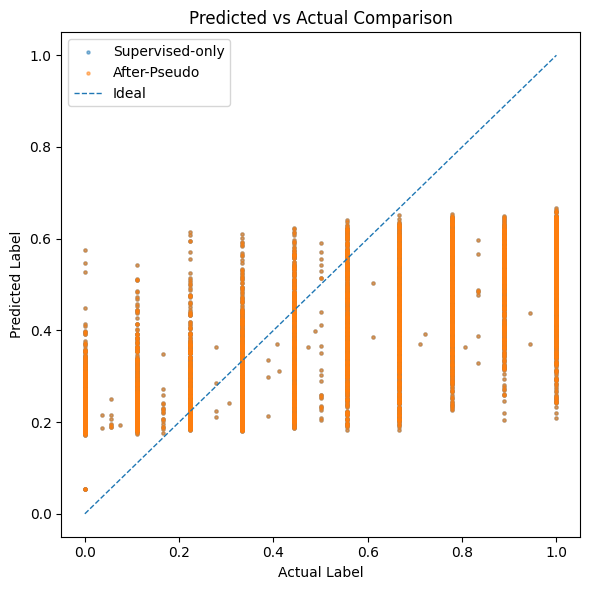

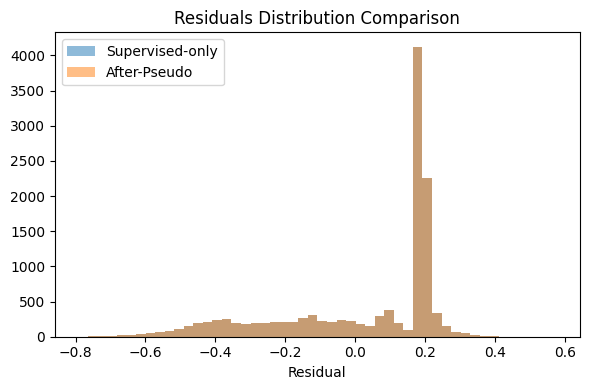

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure the required objects exist
if 'sup_trainer' not in globals() or 'pseudo_trainer' not in globals() or 'test_tok' not in globals():
    raise RuntimeError("Please run the cells that define and train 'sup_trainer', 'pseudo_trainer', and prepare 'test_tok' first.")

# 1) Predictions
sup_out      = sup_trainer.predict(test_tok)
sup_preds    = sup_out.predictions.squeeze(-1)
labels       = sup_out.label_ids.astype(float)
sup_resids   = sup_preds - labels

pseudo_out   = pseudo_trainer.predict(test_tok)
pseudo_preds = pseudo_out.predictions.squeeze(-1)
pseudo_resids= pseudo_preds - labels

# 2) Metrics
def all_metrics(true, pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(true, pred)),
        "MAE":  mean_absolute_error(true, pred),
        "R²":   r2_score(true, pred)
    }

sup_metrics    = all_metrics(labels, sup_preds)
pseudo_metrics = all_metrics(labels, pseudo_preds)

print("🔹 Supervised-only Metrics:", sup_metrics)
print("🔹 After-Pseudo Metrics:  ", pseudo_metrics)

# 3) Bar Chart Comparison
metrics_names = list(sup_metrics.keys())
sup_vals      = [sup_metrics[m] for m in metrics_names]
pseudo_vals   = [pseudo_metrics[m] for m in metrics_names]

x = np.arange(len(metrics_names))
w = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - w/2, sup_vals, width=w, label='Supervised-only')
plt.bar(x + w/2, pseudo_vals, width=w, label='After-Pseudo')
plt.xticks(x, metrics_names)
plt.ylabel('Value')
plt.title('Performance Metrics Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# 4) Predicted vs Actual Overlay
plt.figure(figsize=(6,6))
plt.scatter(labels, sup_preds,    s=5, alpha=0.5, label='Supervised-only')
plt.scatter(labels, pseudo_preds, s=5, alpha=0.5, label='After-Pseudo')
mn = min(labels.min(), sup_preds.min(), pseudo_preds.min())
mx = max(labels.max(), sup_preds.max(), pseudo_preds.max())
plt.plot([mn, mx], [mn, mx], '--', linewidth=1, label='Ideal')
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.title('Predicted vs Actual Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# 5) Residuals Distribution Comparison
plt.figure(figsize=(6,4))
plt.hist(sup_resids,    bins=50, alpha=0.5, label='Supervised-only')
plt.hist(pseudo_resids, bins=50, alpha=0.5, label='After-Pseudo')
plt.xlabel('Residual')
plt.title('Residuals Distribution Comparison')
plt.legend()
plt.tight_layout()
plt.show()
